In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
data_dir = ['/content/drive/My Drive/T1',
                '/content/drive/My Drive/T2',
                '/content/drive/My Drive/T3',
                '/content/drive/My Drive/T4']

Number of images: 836
Number of masks: 836


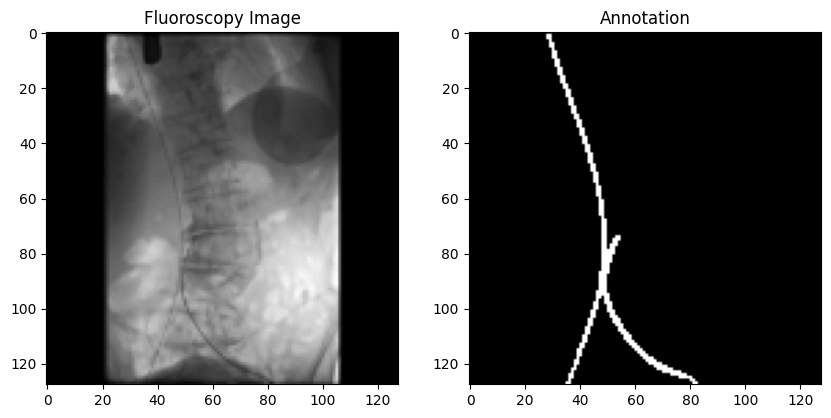

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

data_dirs = [
    '/content/drive/My Drive/T1',
    '/content/drive/My Drive/T2',
    '/content/drive/My Drive/T3',
    '/content/drive/My Drive/T4'
]

# Separate image and mask files based on your naming convention
image_files = []
mask_files = []

for data_dir in data_dirs:
    for f in os.listdir(data_dir):
        if 'Fluoroscopy_Image' in f:
            image_files.append(os.path.join(data_dir, f))
        elif 'Annotation' in f:
            mask_files.append(os.path.join(data_dir, f))

# Sort files to ensure they are paired correctly
image_files.sort()
mask_files.sort()

# Load and preprocess the images and masks
images = []
masks = []

for image_file, mask_file in zip(image_files, mask_files):
    # Load image and mask
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

    # Check if image and mask are loaded correctly
    if image is not None and mask is not None:
        # Normalize image
        image = image / 255.0

        # Resize if necessary (example: resize to 128x128)
        image = cv2.resize(image, (128, 128))
        mask = cv2.resize(mask, (128, 128))

        # Ensure mask is binary
        mask = (mask > 0).astype(np.float32)

        # Expand dimensions to fit the model input shape (batch, height, width, channels)
        image = np.expand_dims(image, axis=-1)
        mask = np.expand_dims(mask, axis=-1)

        # Append to lists
        images.append(image)
        masks.append(mask)
    else:
        print(f"Error loading {image_file} or {mask_file}")

# Convert lists to numpy arrays
images = np.array(images)
masks = np.array(masks)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

# Data augmentation
data_gen_args = dict(rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Fit the data generators
image_datagen.fit(X_train, augment=True)
mask_datagen.fit(y_train, augment=True)

# Create the data generators
seed = 1
batch_size = 32
train_image_generator = image_datagen.flow(X_train, batch_size=batch_size, seed=seed)
train_mask_generator = mask_datagen.flow(y_train, batch_size=batch_size, seed=seed)

# Combine generators into one which yields image and masks
train_generator = zip(train_image_generator, train_mask_generator)

# Validation generator without augmentation
val_image_datagen = ImageDataGenerator()
val_mask_datagen = ImageDataGenerator()

val_image_datagen.fit(X_val, augment=False)
val_mask_datagen.fit(y_val, augment=False)

val_image_generator = val_image_datagen.flow(X_val, batch_size=batch_size, seed=seed)
val_mask_generator = val_mask_datagen.flow(y_val, batch_size=batch_size, seed=seed)

val_generator = zip(val_image_generator, val_mask_generator)

# Verify the loaded data
print(f"Number of images: {len(images)}")
print(f"Number of masks: {len(masks)}")

# Plot some samples
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Fluoroscopy Image')
plt.imshow(X_train[0].squeeze(), cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Annotation')
plt.imshow(y_train[0].squeeze(), cmap='gray')
plt.show()



In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import backend as K
from scipy.ndimage import distance_transform_edt as distance

@tf.keras.utils.register_keras_serializable()
def weighted_binary_crossentropy(weights):
    @tf.keras.utils.register_keras_serializable()
    def loss(y_true, y_pred):
        y_true = K.flatten(y_true)
        y_pred = K.flatten(y_pred)
        loss = K.binary_crossentropy(y_true, y_pred)
        loss = loss * (weights[1] * y_true + weights[0] * (1 - y_true))
        return K.mean(loss)
    return loss

weights = [0.1, 0.9]

@tf.keras.utils.register_keras_serializable()
def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = intersection / (union + tf.keras.backend.epsilon())
    return iou

@tf.keras.utils.register_keras_serializable()
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def rdice_coefficient(y_true, y_pred, smooth=1):
    return dice_coefficient(y_true, y_pred, smooth)

# clDice coefficient
def cl_dice_coefficient(y_true, y_pred, smooth=1):
    def cl_score(mask1, mask2):
        S1 = K.round(K.clip(mask1, 0, 1))
        S2 = K.round(K.clip(mask2, 0, 1))

        def distance_transform(mask):
            return distance(mask).astype(np.float32)

        S1_dt = tf.py_function(distance_transform, [S1], tf.float32)
        S2_dt = tf.py_function(distance_transform, [S2], tf.float32)

        cl_S = (S1 * S2_dt) + (S2 * S1_dt)
        cl_S = K.sum(cl_S, axis=(1, 2, 3))

        return 2 * cl_S / (K.sum(S1, axis=(1, 2, 3)) + K.sum(S2, axis=(1, 2, 3)) + K.epsilon())

    dice = dice_coefficient(y_true, y_pred, smooth)
    cl_dice = cl_score(y_true, y_pred)
    return (dice + cl_dice) / 2

In [ ]:
# Define the directory in Google Drive
drive_directory = '/content/drive/MyDrive/UNET_MODELT1'

# Define file paths
model_save_path = os.path.join(drive_directory, 'unet_final_modelT.keras')
history_save_path = os.path.join(drive_directory, 'training_historyT.pkl')
predictions_save_path = os.path.join(drive_directory, 'model_predictionsT.npy')

In [ ]:
def unet_model(input_size=(128, 128, 1)):
    inputs = Input(input_size)

    # Encoding path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Dropout(0.3)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoding path
    u5 = UpSampling2D((2, 2))(c4)
    u5 = Concatenate()([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Dropout(0.1)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])
    # Compile the model with the weighted loss function
    model.compile(optimizer='adam', loss= weighted_binary_crossentropy(weights), metrics=['accuracy',iou_metric, dice_coefficient,rdice_coefficient, cl_dice_coefficient,tf.keras.metrics.AUC()])

    return model

model = unet_model(input_size=(128, 128, 1))

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
model = unet_model()

# Calculate steps_per_epoch and validation_steps
batch_size = 32
steps_per_epoch = max(1, len(X_train) // batch_size)
validation_steps = max(1, len(X_val) // batch_size)

# Define the learning rate scheduler callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001) # changed from 0.0001 to 0.00001 , I think their will be some improvements
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(model_save_path, save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=35,
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping, reduce_lr,model_checkpoint])
#model.save(model_save_path)

Epoch 1/35
20/20 [==============================] - 19s 729ms/step - loss: 0.0660 - accuracy: 0.9133 - iou_metric: 0.0015 - dice_coefficient: 0.0447 - rdice_coefficient: 0.0447 - cl_dice_coefficient: 0.0333 - auc_12: 0.5005 - val_loss: 0.0617 - val_accuracy: 0.9718 - val_iou_metric: 0.0000e+00 - val_dice_coefficient: 0.0549 - val_rdice_coefficient: 0.0549 - val_cl_dice_coefficient: 0.0266 - val_auc_12: 0.5587 - lr: 0.0010
Epoch 2/35
20/20 [==============================] - 14s 698ms/step - loss: 0.0541 - accuracy: 0.9574 - iou_metric: 0.0000e+00 - dice_coefficient: 0.0556 - rdice_coefficient: 0.0556 - cl_dice_coefficient: 0.0278 - auc_12: 0.6073 - val_loss: 0.0611 - val_accuracy: 0.9716 - val_iou_metric: 0.0000e+00 - val_dice_coefficient: 0.0519 - val_rdice_coefficient: 0.0519 - val_cl_dice_coefficient: 0.0279 - val_auc_12: 0.6012 - lr: 0.0010
Epoch 3/35
20/20 [==============================] - 14s 696ms/step - loss: 0.0525 - accuracy: 0.9580 - iou_metric: 0.0000e+00 - dice_coefficient

In [ ]:
# Evaluate the model on the training data
test_metrics = model.evaluate(X_train, y_train, batch_size=batch_size)

# Unpack the returned metrics
(test_loss, test_accuracy, test_iou_metric, test_dice_coefficient,
 test_rdice_coefficient, test_cl_dice_coefficient, test_auc) = test_metrics

# Print the metrics
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test IoU Metric: {test_iou_metric:.4f}')
print(f'Test Dice Coefficient: {test_dice_coefficient:.4f}')
print(f'Test RDice Coefficient: {test_rdice_coefficient:.4f}')
print(f'Test clDice Coefficient: {test_cl_dice_coefficient:.4f}')
print(f'Test AUC: {test_auc:.4f}')

21/21 [==============================] - 7s 346ms/step - loss: 0.0173 - accuracy: 0.9631 - iou_metric: 0.3870 - dice_coefficient: 0.4055 - rdice_coefficient: 0.4055 - cl_dice_coefficient: 0.7762 - auc_12: 0.9820
Test Loss: 0.0173
Test Accuracy: 0.9631
Test IoU Metric: 0.3870
Test Dice Coefficient: 0.4055
Test RDice Coefficient: 0.4055
Test clDice Coefficient: 0.7762
Test AUC: 0.9820


1/1 [==============================] - 0s 161ms/step


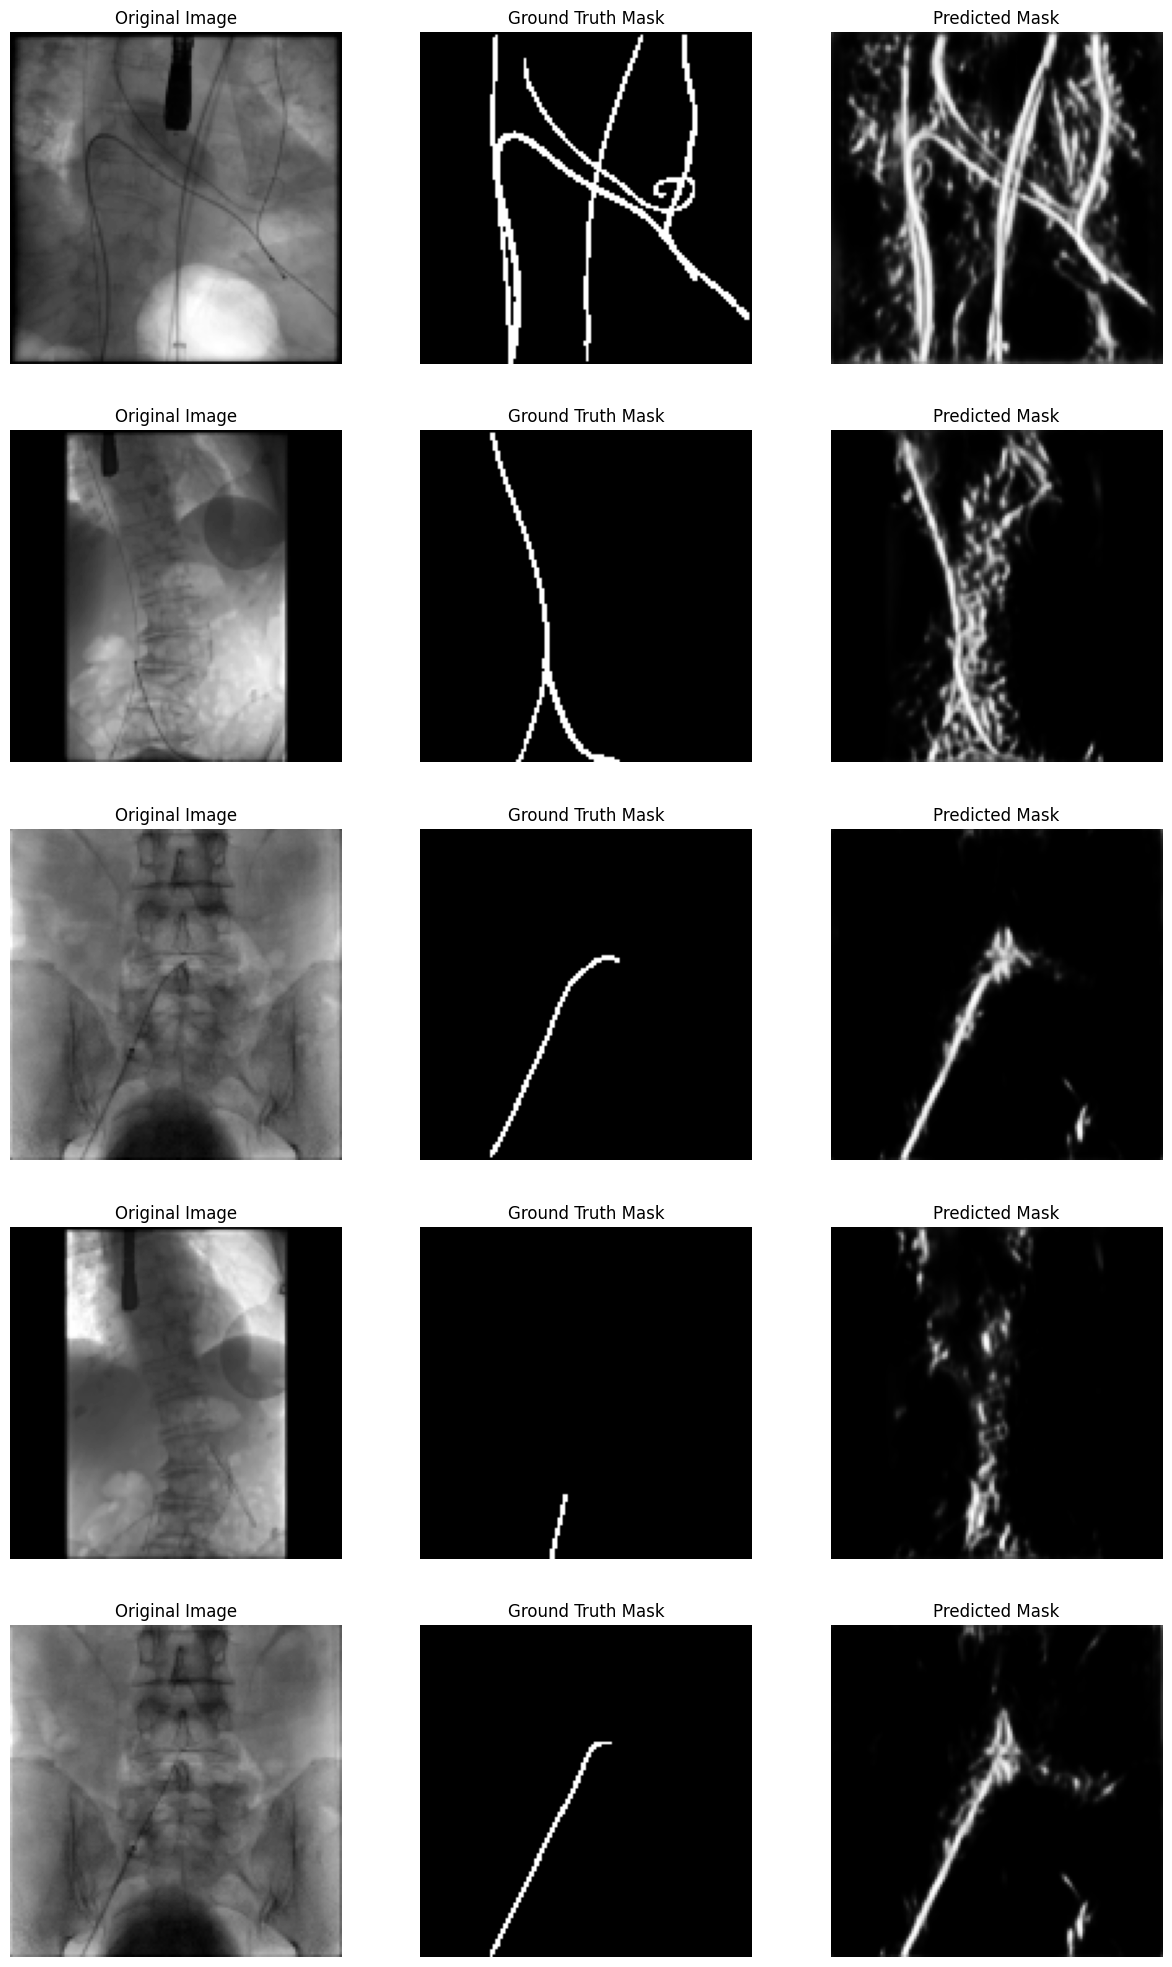

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample_images(model, images, masks, num_samples=5):
    # Shuffle indices to select random samples
    indices = np.arange(len(images))
    np.random.shuffle(indices)
    selected_indices = indices[:num_samples]

    selected_images = images[selected_indices]
    selected_masks = masks[selected_indices]

    predictions = model.predict(selected_images)

    plt.figure(figsize=(15, num_samples * 5))

    for i in range(num_samples):
        # Original image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(np.squeeze(selected_images[i]), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        # Ground truth mask
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(np.squeeze(selected_masks[i]), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        # Predicted mask
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(np.squeeze(predictions[i]), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.show()

# Example usage
# Assuming `model`, `images`, and `masks` are already defined
plot_sample_images(model, images, masks)



In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os

def load_images_and_masks_from_files(file_list, folder_path, image_prefix='Fluoroscopy_Image', mask_prefix='Annotation', image_size=(128, 128)):
    images = []
    masks = []

    for file in file_list:
        if image_prefix in file:
            # Load image
            image_path = os.path.join(folder_path, file)
            image = load_img(image_path, target_size=image_size, color_mode='grayscale')
            image = img_to_array(image)
            images.append(image)
        elif mask_prefix in file:
            # Load mask
            mask_path = os.path.join(folder_path, file)
            mask = load_img(mask_path, target_size=image_size, color_mode='grayscale')
            mask = img_to_array(mask)
            masks.append(mask)

    return np.array(images), np.array(masks)

# Load unseen test data from T1, T2, and T4 folders
folder_paths = ['/content/drive/My Drive/phantom']

X_test = []
y_test = []

for folder_path in folder_paths:
    all_files = os.listdir(folder_path)
    images, masks = load_images_and_masks_from_files(all_files, folder_path)
    X_test.append(images)
    y_test.append(masks)

# Combine the data from different folders
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

# Preprocess the data
X_test = X_test.astype('float32') / 255.0
y_test = y_test.astype('float32') / 255.0

# Ensure masks are binary
y_test = (y_test > 0).astype(np.float32)

# Evaluate the model on the test data
test_metrics = model.evaluate(X_test, y_test, batch_size=batch_size)

# Unpack the returned metrics
(test_loss, test_accuracy, test_iou_metric, test_dice_coefficient,
 test_rdice_coefficient, test_cl_dice_coefficient, test_auc) = test_metrics

# Print the metrics
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test IoU Metric: {test_iou_metric:.4f}')
print(f'Test Dice Coefficient: {test_dice_coefficient:.4f}')
print(f'Test RDice Coefficient: {test_rdice_coefficient:.4f}')
print(f'Test clDice Coefficient: {test_cl_dice_coefficient:.4f}')
print(f'Test AUC: {test_auc:.4f}')


63/63 [==============================] - 25s 398ms/step - loss: 0.0273 - accuracy: 0.9164 - iou_metric: 0.0945 - dice_coefficient: 0.1011 - rdice_coefficient: 0.1011 - cl_dice_coefficient: 0.2574 - auc_12: 0.8874
Test Loss: 0.0273
Test Accuracy: 0.9164
Test IoU Metric: 0.0945
Test Dice Coefficient: 0.1011
Test RDice Coefficient: 0.1011
Test clDice Coefficient: 0.2574
Test AUC: 0.8874


1/1 [==============================] - 0s 21ms/step


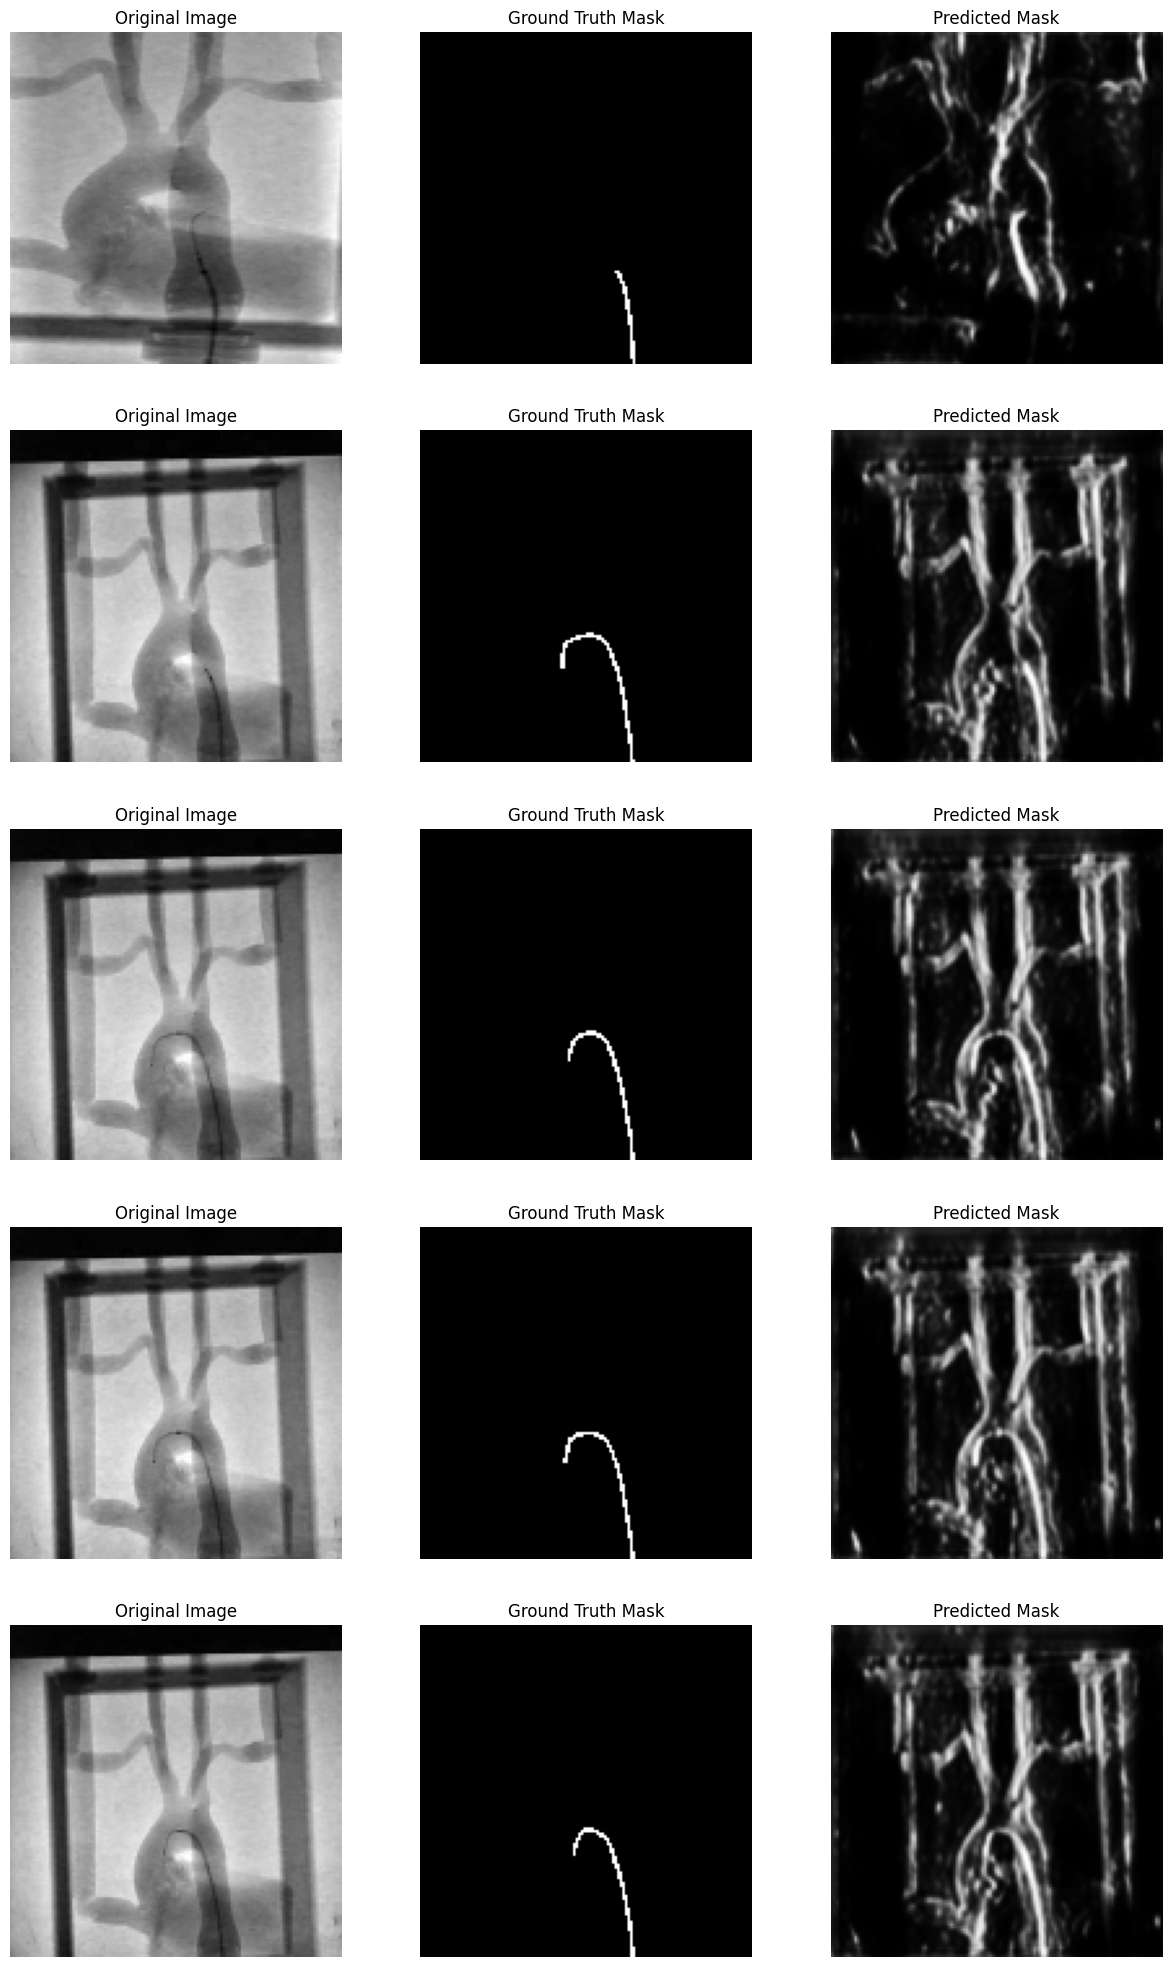

In [ ]:
predictions = model.predict(X_val)

def plot_predictions(model, X_val, y_val, num_samples=5):
    # Predict masks for the validation images
    predictions = model.predict(X_val[:num_samples])

    plt.figure(figsize=(15, num_samples * 5))

    for i in range(num_samples):
        # Original image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(np.squeeze(X_val[i]), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        # Ground truth mask
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(np.squeeze(y_val[i]), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        # Predicted mask
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(np.squeeze(predictions[i]), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.show()

# Call the function to plot
plot_predictions(model, X_test, y_test)